<a href="https://colab.research.google.com/github/mpv88/DeepLearning2022/blob/main/First_assignment_13112022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lorenzobasile/DeepLearning2022/blob/main/gradient_descent.ipynb)


#First assignment - 11/2022 - *mattia pividori (s284690)*
---


- 1. Read carefully the paper [Learning representations by back-propagating errors](https://www.iro.umontreal.ca/~vincentp/ift3395/lectures/backprop_old.pdf)
- 2. Reproduce in PyTorch (or any other DL library you like) experiment 1. Try to be as close as possible to the original protocol regarding network architecture, activation function, training algorithm and parameter initialization.
    - Inspect the weights you obtained and check if they provide a solution to the problem
    - Compare the solution to the solution reported in the paper
- 3. Write a small report (1 page) about your experiment and what you
learned about that. The report should be a jupyter notebook with text
cells that describe the non-trivial parts of your work.

First we import the required Python libraries. we also fix a seed for reproducibility of our results.

In [1]:
import torch
import matplotlib.pyplot as plt

torch.manual_seed(1234)

Here we create a synthetic dataset, in line with what described into "Learning representations by back-propagating errors" by Rumelhart et aliis (1986).
To this purpose we define three auxiliary functions: 
 

*   "to_binary" serves the purpose of first, converting an integer number to its
binary counterparty, then extending the binary representation of the number to a desired number of chars (corresponding to the desired vectors' length); finally, if the binary representation itself does not fill the required length already, the remaining (empty) places are padded with zeros. 


*   "check_symmetry" aims at verifying if a given vector is symmetric or not by means of three conditions: if the number of columns of a given vector is not even, then vector is not symmetrical (print of 0); if instead is even, we check elementwise if the pairs 'first element-last element' -from vector's start up to midpoint- contain two identical elements, if it is the case we have symmetry (print of 1), otherwise we fall again into the asymmetrical case (print of 0).

*   "create_dataset" is a functions which makes use of the previous helper functions to easily create two arrays: the X which contains our dataset with synthetic observations, and y which constitutes the ground truth. 

Given that we opt for a (64-row X 6-column) dataset, where each vector is made of binary chars (0 or 1) -to be in line with what proposed in the original paper-, we verify empirically that in this space we end up with a quite unbalanced dataset including just 8 symmetric observations.


In [10]:
def to_binary(input_number, vector_lenght):
  '''transforms decimals to binaries and leading pad'''
  return [int(_) for _ in '{0:b}'.format(input_number).zfill(vector_lenght)]

def check_symmetry(input_vector):
  '''returns 1 if a vector is symmetrical, 0 otherwise'''
  if len(input_vector)%2 != 0: return float(0)
  else:
    for i in range(len(input_vector)//2):
      if input_vector[i] != input_vector[-(1+i)]: 
        return float(0)
    return float(1)

def create_dataset(size):
  '''generates dataset (X) and ground truth (y)'''
  X = torch.tensor([to_binary(_, size) for _ in range(2**size)], dtype=torch.float32, requires_grad=True)
  y = torch.tensor([check_symmetry(X[_, :]) for _ in range(2**size)])
  return X, y
#-------------------------------------------------------------------------------

# sample dataset creation
vector_size = 6 # see fig. [1] paper
X, y = create_dataset(vector_size) # see fig. [1] paper

# check total number of symmetric obs within the dataset and which are them:
print(torch.sum(y)) # result is 8
[print(X[_],y[_]) for _ in range(2**vector_size) if y[_].item()==1]

tensor(8.)
tensor([0., 0., 0., 0., 0., 0.], grad_fn=<SelectBackward0>) tensor(1.)
tensor([0., 0., 1., 1., 0., 0.], grad_fn=<SelectBackward0>) tensor(1.)
tensor([0., 1., 0., 0., 1., 0.], grad_fn=<SelectBackward0>) tensor(1.)
tensor([0., 1., 1., 1., 1., 0.], grad_fn=<SelectBackward0>) tensor(1.)
tensor([1., 0., 0., 0., 0., 1.], grad_fn=<SelectBackward0>) tensor(1.)
tensor([1., 0., 1., 1., 0., 1.], grad_fn=<SelectBackward0>) tensor(1.)
tensor([1., 1., 0., 0., 1., 1.], grad_fn=<SelectBackward0>) tensor(1.)
tensor([1., 1., 1., 1., 1., 1.], grad_fn=<SelectBackward0>) tensor(1.)


[None, None, None, None, None, None, None, None]

In the next step we set up the parameters for our simple Multi Layer Perceptron, in line with what is our understanding of the original paper.
The input layer will get a size of 6 (in line with defined input vectors), while the single hidden layer is going to be composed of two hidden units.
Finally, being the problem at hand a symmetry detection problem, we can imagine it as a binary classification problem: so it is sufficient for the output layer to have just 1-dimension (i.e. 1 will indicate symmetry, 0 asymmetry).
In line with what presented in the paper (see formula [2]), the activation function of choice for our MLP will be a logistic function (a sigmoid curve).
We also enable the opportunity to have a bias in our MLP, as explicitly cited in Fig.1 of the paper and in the results of the experiment.

In [11]:
# setup MLP specifications

n_input = X.size()[1]       # input size corresponds to the size of 1D vectors (1x6)
n_hidden_1 = 2              # hidden nodes
n_output = 1                # output nodes for binary classifier
bias_dummy = True           # bias enabled
activation_function = torch.nn.Sigmoid() # see formula [2] paper

In the following step we simply encode the information and the parameters defined at previous step, inheriting from a pythorch.module class and thus defining our deep-learning "binary classifier".
Notice the fact that, following the instructions of Fig.1 in the paper, we have tried to replicate the fact that "[...] initial weights were random and were uniformly distributed between -0.3 and 0.3". 
Finally, as for us it was not clear in the paper if the same operation was applied or not to bias terms, we opted for *not* applying it, anyway we tried to run our model even applying it without significant differences in the results.
At the end of the cell you may find a useful print with a recap of the newly created and initialised model, and a sketch of its structure.

In [12]:
# setup Multi-Layer Perceptron (MLP) class

class binary_classifier(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = torch.nn.Linear(in_features=n_input, out_features=n_hidden_1, bias=bias_dummy) # first layer: from input 1D vector (1x6) to hidden layer of made of 2 nodes
    self.layer_2 = torch.nn.Linear(in_features=n_hidden_1, out_features=n_output, bias=bias_dummy) # second layer: from 2 node hidden layer to output (1/0 binary classification problem)
    self.activation = activation_function
    torch.nn.init.uniform_(self.layer_1.weight, -0.3, 0.3)
    torch.nn.init.uniform_(self.layer_2.weight, -0.3, 0.3)
    #torch.nn.init.uniform_(self.layer_1.bias,-0.3,0.3)
    #torch.nn.init.uniform_(self.layer_2.bias,-0.3,0.3)

  def forward(self, X):
    X = self.activation(self.layer_1(X))
    X = self.activation(self.layer_2(X))
    return X
#-------------------------------------------------------------------------------

# initialize model
model = binary_classifier()
# first check of initialized mlp parameters
print(model)
for name,param in model.named_parameters():
    print(name, param.data)

binary_classifier(
  (layer_1): Linear(in_features=6, out_features=2, bias=True)
  (layer_2): Linear(in_features=2, out_features=1, bias=True)
  (activation): Sigmoid()
)
layer_1.weight tensor([[ 0.2303,  0.1850,  0.1517,  0.2393,  0.1103,  0.1595],
        [ 0.2489, -0.0604, -0.2340, -0.1475, -0.0400, -0.0330]])
layer_1.bias tensor([ 0.1159, -0.1653])
layer_2.weight tensor([[-0.0020,  0.1719]])
layer_2.bias tensor([-0.6145])


In the following cell we define the last two elements necessary before training our model:

*   the loss function: defined below are two alternatives ready to be used on our MLP; the first is directly coming from formula [3] in paper and defines "the total error in the performance of the network [...] by comparing actual and desired output vectors for every case"; the second is a Binary Cross Entropy loss (details at https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) a de facto standard for evaluating the performance of binary classification tasks.
*   the optimizer: the choice is for the stochastic gradient descent (SGD) optimizer (details at https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) where we specify some options such as the learning rate and the momentum. In fact, as per formula [9] in paper and the details outlined in Fig. 1 we understand that the learning rate should be equal to the ε parameter, fixed to 0.1, while the momentum is set equal to the α parameter (0.9), which enables an "acceleration method in which the current gradient is used to modfiy the velocity of the point instead of its position".
The last parameter is the total number of epochs (i.e. "sweeps" in the paper") for training the model, which is set here to 1425.



In [13]:
# loss functions: 2 alternatives

def total_error(y_predicted, y_truth):
            return 0.5 * torch.sum((y_predicted-y_truth) **2) # see formula [3] paper
te_loss = total_error

bce_loss = torch.nn.BCELoss() # used Binary Cross Entropy loss


# optimizer: stochastic gradient descent (optionally with momentum)

num_epochs = 1425  # i.e. sweeps see fig. [1] paper
epsilon = 0.1 # i.e. ε of equation [9], see fig. [1] paper
alpha = 0.9 # i.e. # i.e. α of equation [9], see fig. [1] paper
optimizer = torch.optim.SGD(model.parameters(), lr=epsilon, momentum=alpha) # gradient descent with momentum

In the next cell we define the function enabling the SGD training by means of the iterative process already explained in the previouses labs, which encopasses some steps that we are going to repeat for a number of times equal to the stated epochs. In detail, the sub-steps include first a loop over data, then a first forward pass which leads to a first guess of the output, then the computation of the loss follows, the past gradients are erased as convenient within the Pytorch framework; thus the gradients are computed within a backward pass steps which ends up with the updating of the initial parameters.

In [25]:
def train_model(X, y, model, loss_fn, optimizer, num_epochs):
  model.train()
  train_loss = []
  for epoch in range(num_epochs):
    y_predicted = model(X) # forward pass, get model's output
    loss = te_loss(y_predicted, y.unsqueeze(1)) # calculate the loss 
    optimizer.zero_grad() # gradients' reset (avoid loop cumulation)
    loss.backward() # backward propagation on current loss
    optimizer.step() # update params
    print("Loss in iteration: "+str(epoch)+" is: "+str(loss.item()))
    train_loss.append(loss.item())
  return train_loss

In the short following step we finally train our MLP model, and check the resulting parameters Θ for our model (weights and biases), together with the trend of the loss function while increasing model's iterations.

In [26]:
# model run
train_loss = train_model(X, y, model, te_loss, optimizer, num_epochs)
#train_model(X, y, model, te_loss, optimizer, num_epochs)

# final check of mlp params
for name, param in model.named_parameters():
    print(name, param.data)

Loss in iteration: 0 is: 2.80287504196167
Loss in iteration: 1 is: 2.8028721809387207
Loss in iteration: 2 is: 2.8028690814971924
Loss in iteration: 3 is: 2.802866220474243
Loss in iteration: 4 is: 2.802863121032715
Loss in iteration: 5 is: 2.8028602600097656
Loss in iteration: 6 is: 2.802856683731079
Loss in iteration: 7 is: 2.802853584289551
Loss in iteration: 8 is: 2.8028509616851807
Loss in iteration: 9 is: 2.8028476238250732
Loss in iteration: 10 is: 2.802845001220703
Loss in iteration: 11 is: 2.802841901779175
Loss in iteration: 12 is: 2.8028388023376465
Loss in iteration: 13 is: 2.802835464477539
Loss in iteration: 14 is: 2.80283260345459
Loss in iteration: 15 is: 2.8028297424316406
Loss in iteration: 16 is: 2.8028268814086914
Loss in iteration: 17 is: 2.802823781967163
Loss in iteration: 18 is: 2.802820920944214
Loss in iteration: 19 is: 2.8028173446655273
Loss in iteration: 20 is: 2.8028147220611572
Loss in iteration: 21 is: 2.80281138420105
Loss in iteration: 22 is: 2.8028090

Finally, we plot the loss which shows that for the chosen loss function (i.e. total error), model seems not to be fully stabilized after 30 epochs, even if the marginal reduction in the loss seems decreasing at the increase of the optimization steps.

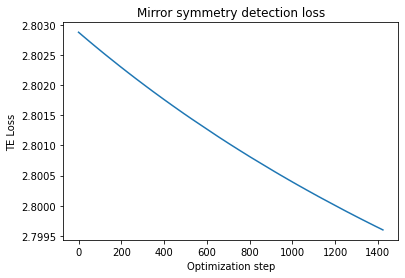

In [27]:
# Visualize loss during training

plt.figure()
plt.title("Mirror symmetry detection loss")
plt.plot(train_loss)
plt.xlabel("Optimization step")
plt.ylabel("TE Loss")
plt.show()

#Conclusions
---
The inspection of the final weights does not seem to lead to the same results of the original paper (i.e. weights following the 1:2:4 ratio in a symmetric pattern, negative biases for hidden units, positive for the output unit).
Indeed we notice a quite significant symmetry in the weights we obtained, moreover also our output bias is positive, but the biases in the hidden layer have both negative and positive sign and it doesn't seem to hold the 1:2:4 ratio in the resulting weights.
Possible ways to improve our results may be to re-think the way we created our dataset, investigating if we may have misinterpreted some elements of the original paper. Another improvement may be to increase the total number of epochs, to try to refine the resulting model, possibly reducing losses. A third direction which may be worth exploring is changing the optimizer, to see if alternatives such as Adam, RMSprop or Adagrad lead to results more in line with the original work. Finally, a word of caution even on the pseudo-random seed adopted, as of course the stochasticity introduced in our experiment may lead to elements which impair the direct comparison with the original work. 